# **Reflexion**

Reflexion is a novel framework that introduces verbal reinforcement learning for language agents, allowing them to learn from past experiences and improve decision-making through self-reflection. Unlike traditional reinforcement learning (RL), which relies on extensive training and parameter updates, Reflexion enhances agent performance using natural language-based self-improvement without modifying model weights.

### Key Concepts of Reflexion:
1. **Verbal Reinforcement Learning**: Instead of numerical rewards, Reflexion agents receive textual feedback in the form of self-reflections, helping them identify mistakes and refine future decisions.
2. **Episodic Memory for Self-Learning**: Reflexion maintains a memory buffer where past self-reflections are stored, enabling the agent to recall past mistakes and refine its approach dynamically.
3. **Three-Component Framework**:
   - **Actor**: The LLM agent that performs tasks and generates outputs.
   - **Evaluator**: Assesses the performance of the agent’s output, providing feedback.
   - **Self-Reflection Model**: Generates verbal reinforcement signals that help the agent improve future decisions.
4. **Flexible Feedback Mechanisms**:
   - Reflexion supports multiple forms of feedback, including binary signals, scalar values, heuristic assessments, and self-generated evaluations.
   - It enables learning in various environments such as programming, decision-making, and reasoning tasks.
5. **Enhancing Performance Across Tasks**:
   - **Decision-Making**: Reflexion improves multi-step reasoning by refining choices through iterative self-evaluation.
   - **Programming**: It employs self-generated unit tests to refine and debug code, achieving **91% pass@1 accuracy** on HumanEval, outperforming GPT-4’s 80%.
   - **Language Reasoning**: Reflexion boosts performance in reasoning-intensive tasks such as HotpotQA by incorporating iterative improvements based on verbal feedback.

### Advantages of Reflexion:
- **Eliminates the Need for Model Fine-Tuning**: Unlike standard RL methods that require costly fine-tuning, Reflexion refines outputs without updating model parameters.
- **Improves Generalization**: Reflexion enables agents to learn from diverse failures and adapt across different domains, from programming to multi-step decision-making.
- **More Efficient Learning**: By replacing trial-and-error learning with self-reflection, Reflexion **reduces sample complexity**, requiring fewer attempts to improve performance.
- **Enhanced Interpretability**: The explicit self-reflection process allows users to **track and analyze** the agent’s learning path, improving trust and reliability in AI decision-making.

By introducing self-reflective feedback loops, Reflexion represents a major step toward autonomous, adaptive, and interpretable AI agents. This paradigm shift moves beyond static model predictions toward agents that can critically assess and refine their own outputs, bringing us closer to more effective AI-driven problem-solving across multiple domains.

paper link: https://arxiv.org/pdf/2303.11366

Code Reference: https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/reflexion/reflexion.ipynb

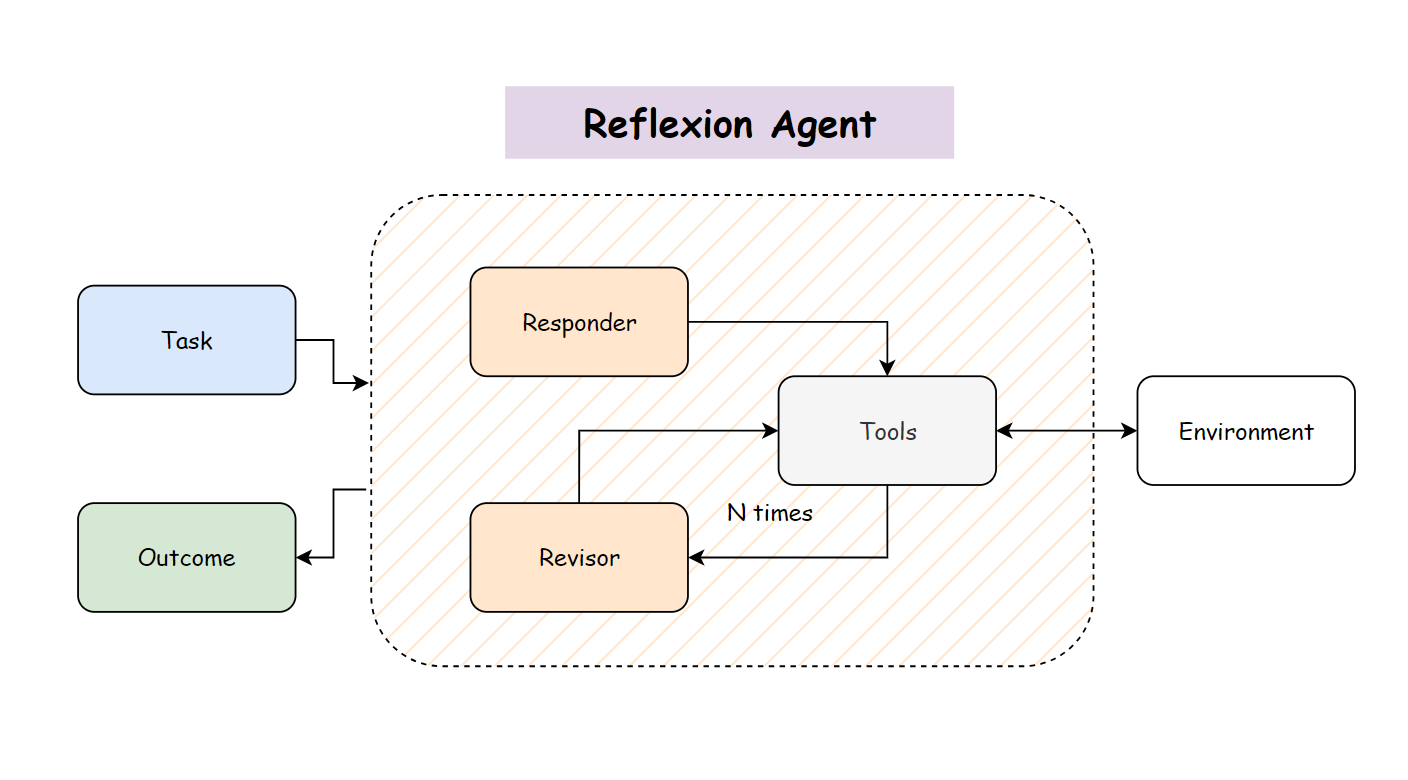

In [ ]:
!pip install --q langgraph langchain_openai langchain_community

In [ ]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

In [ ]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

In [ ]:
# Set up Tavily Web Search API
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_tool = TavilySearchResults(max_results=5)

In [ ]:
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import ValidationError

from pydantic import BaseModel, Field


class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous")


class AnswerQuestion(BaseModel):
    """Answer the question. Provide an answer, reflection, and then follow up with search queries to improve the answer."""

    answer: str = Field(description="~250 word detailed answer to the question.")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    search_queries: list[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )


class ResponderWithRetries:
    def __init__(self, runnable, validator):
        self.runnable = runnable
        self.validator = validator

    def respond(self, state: dict):
        response = []
        # Convert the initial state dictionary to a list of messages
        messages = state["messages"]
        for attempt in range(3):
            response = self.runnable.invoke(
                {"messages": messages}, {"tags": [f"attempt:{attempt}"]}
            )
            try:
                self.validator.invoke(response)
                return {"messages": response}
            except ValidationError as e:
                # Append new messages to the existing list
                messages.extend(
                    [
                        response,
                        ToolMessage(
                            content=f"{repr(e)}\n\nPay close attention to the function schema.\n\n"
                            + self.validator.schema_json()
                            + " Respond by fixing all validation errors.",
                            tool_call_id=response.tool_calls[0]["id"],
                        ),
                    ]
                )
                # Update the state with the modified list of messages
                state["messages"] = messages

        return {"messages": response}

In [ ]:
import datetime

actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are expert researcher.
Current time: {time}

1. {first_instruction}
2. Reflect and critique your answer. Be severe to maximize improvement.
3. Recommend search queries to research information and improve your answer.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "\n\n<system>Reflect on the user's original question and the"
            " actions taken thus far. Respond using the {function_name} function.</reminder>",
        ),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)
initial_answer_chain = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~250 word answer.",
    function_name=AnswerQuestion.__name__,
) | llm.bind_tools(tools=[AnswerQuestion])
validator = PydanticToolsParser(tools=[AnswerQuestion])

first_responder = ResponderWithRetries(
    runnable=initial_answer_chain, validator=validator
)

In [ ]:
example_question = "Why is reflection useful in AI?"
initial = first_responder.respond(
    {"messages": [HumanMessage(content=example_question)]}
)

<ipython-input-5-11906d12f482>:47: PydanticDeprecatedSince20: The `schema_json` method is deprecated; use `model_json_schema` and json.dumps instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  + self.validator.schema_json()
<ipython-input-5-11906d12f482>:47: PydanticDeprecatedSince20: The `schema_json` method is deprecated; use `model_json_schema` and json.dumps instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  + self.validator.schema_json()


In [ ]:
revise_instructions = """Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
        - You MUST include numerical citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
            - [1] https://example.com
            - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.
"""


# Extend the initial answer schema to include references.
# Forcing citation in the model encourages grounded responses
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question. Provide an answer, reflection,

    cite your reflection with references, and finally
    add search queries to improve the answer."""

    references: list[str] = Field(
        description="Citations motivating your updated answer."
    )


revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions,
    function_name=ReviseAnswer.__name__,
) | llm.bind_tools(tools=[ReviseAnswer])
revision_validator = PydanticToolsParser(tools=[ReviseAnswer])

revisor = ResponderWithRetries(runnable=revision_chain, validator=revision_validator)

In [ ]:
import json

revised = revisor.respond(
    {
        "messages": [
            HumanMessage(content=example_question),
            initial["messages"],
            ToolMessage(
                tool_call_id=initial["messages"].tool_calls[0]["id"],
                content=json.dumps(
                    tavily_tool.invoke(
                        {
                            "query": initial["messages"].tool_calls[0]["args"][
                                "search_queries"
                            ][0]
                        }
                    )
                ),
            ),
        ]
    }
)
revised["messages"]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GEwvkL477bOgsdqS1LonAxbq', 'function': {'arguments': '{"answer": "Reflection in AI is crucial for enhancing performance, learning, decision-making, and safety. It enables AI systems to evaluate past actions and outcomes, enhancing their ability to adjust strategies and improve future performance. Through iterative feedback loops and memory mechanisms, AI can self-evaluate and refine its outputs, similar to human learning processes [1][2].\\n\\nReflection is instrumental in debugging AI systems by allowing models to identify and learn from their mistakes. This helps in pinpointing algorithmic misinterpretations and making precise corrections [3]. Furthermore, reflection enhances the transparency and interpretability of AI decision-making, which is crucial for developers and users to understand the rationale behind AI actions [4].\\n\\nMoreover, it contributes to AI ethics and safety by reviewing actions against ethical

In [ ]:
from langchain_core.tools import StructuredTool

from langgraph.prebuilt import ToolNode


def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    return tavily_tool.batch([{"query": query} for query in search_queries])


tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
    ]
)

In [ ]:
from typing import Literal

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


MAX_ITERATIONS = 5
builder = StateGraph(State)
builder.add_node("draft", first_responder.respond)


builder.add_node("execute_tools", tool_node)
builder.add_node("revise", revisor.respond)
# draft -> execute_tools
builder.add_edge("draft", "execute_tools")
# execute_tools -> revise
builder.add_edge("execute_tools", "revise")

# Define looping logic:


def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i


def event_loop(state: list):
    # in our case, we'll just stop after N plans
    num_iterations = _get_num_iterations(state["messages"])
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"


# revise -> execute_tools OR end
builder.add_conditional_edges("revise", event_loop, ["execute_tools", END])
builder.add_edge(START, "draft")
graph = builder.compile()

In [ ]:
events = graph.stream(
    {"messages": [("user", "How should we handle the climate crisis?")]},
    stream_mode="values",
)
for i, step in enumerate(events):
    print(f"Step {i}")
    step["messages"][-1].pretty_print()

Step 0
================================ Human Message =================================

How should we handle the climate crisis?


<ipython-input-5-11906d12f482>:47: PydanticDeprecatedSince20: The `schema_json` method is deprecated; use `model_json_schema` and json.dumps instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  + self.validator.schema_json()


Step 1
================================== Ai Message ==================================
Tool Calls:
  AnswerQuestion (call_qETkkv74NYDKWj86AuTDf4Ek)
 Call ID: call_qETkkv74NYDKWj86AuTDf4Ek
  Args:
    answer: Addressing the climate crisis requires a multifaceted approach that involves governments, businesses, communities, and individuals working together to mitigate and adapt to the adverse effects of climate change. Firstly, international cooperation is paramount, emphasizing the strengthening of global agreements like the Paris Agreement, which aims to limit global warming to well below 2 degrees Celsius above pre-industrial levels. Policymaking should foster sustainable energy transition, prioritizing investments in renewable energy sources (such as solar and wind), and phasing out fossil fuels.

On a national and local level, governments can introduce policies that incentivize green innovation, enforce emissions regulations, and implement carbon pricing mechanisms to discourage car

<ipython-input-5-11906d12f482>:47: PydanticDeprecatedSince20: The `schema_json` method is deprecated; use `model_json_schema` and json.dumps instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  + self.validator.schema_json()


Step 3
================================== Ai Message ==================================
Tool Calls:
  ReviseAnswer (call_8ahftUxkJ3jWFivpTSkTZibA)
 Call ID: call_8ahftUxkJ3jWFivpTSkTZibA
  Args:
    answer: Addressing the climate crisis requires a multifaceted approach involving international, national, and individual efforts. Strengthening global agreements such as the Paris Agreement is crucial. This agreement aims to limit global warming to below 2°C above pre-industrial levels through national commitments and fostering sustainable energy transitions. Nations should focus on renewable energy investments and phasing out fossil fuels. For instance, India's rapid solar power expansion and Mexico's waste-to-energy initiatives showcase successful policies. [1][2]

National policies should promote green innovation and impose carbon pricing to deter carbon-intensive practices. Businesses must adopt sustainable practices, like energy-efficient technologies and supply chain sustainability, a